In [2]:
#导入相关包
import pandas as pd
import numpy as np
from snownlp import SnowNLP #情感分析
import jieba
import pyLDAvis.gensim       #LDA可视化
import wordcloud             #词云
import os, codecs
import seaborn as sns
from pylab import mpl
import jieba.posseg as pseg
import matplotlib.pyplot as plt
from collections import Counter
from gensim import corpora,models

# 预处理

In [3]:
#导入数据
df=pd.read_csv('F:\乡村庄园.csv')
df1= df['text']
#df1.head()

In [4]:
#查询重复值
df1.duplicated().value_counts() 
#处理重复值
df2= df1.drop_duplicates()
df2.duplicated().value_counts()

False    4102
Name: text, dtype: int64

In [5]:
#去除短句，保留长度大于5的数据
df3 = df2[df2.str.len()>5]
df3 = df3.reset_index(drop=True)
data = df3.tolist()            #list形式

In [6]:
df3.head()

0    非常棒，如果去山西看大院或者民居，绝对不容错过，首先有规模，12万平方米，乔家一个院，常家两...
1    晋中最好玩最值得一去的地方啦。交通便利，市内公车一小时直达。庄园很大很美丽，多部影视剧的取景...
2    乔家大院、王家大院、常家庄园相比，感觉常家庄园最好，王家大院次之，乔家大院相比之下根本不值一...
3    这个景点不适合冬天去游览的，我们2月初从太原站对面坐901到榆次老城再转12才到常家庄园的，...
4    很不错，值得一去，儒家思想，比乔家大院有思想，后花园也不错，景色宜人，流连忘返啊，是许多电影...
Name: text, dtype: object

# 分词

In [7]:
def load_stopword():
    '''
    加载停用词表
    :return: 返回停用词的列表
    '''
    f_stop = open('E:\课程相关\大三下\综合课程设计\stopWord.txt','r',encoding='UTF-8')
    sw = [line.strip() for line in f_stop]
    f_stop.close()
    sw.append('\n')
    return sw

<>:6: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \s
<ipython-input-7-4c5bede52888>:6: DeprecationWarning: invalid escape sequence \s
  f_stop = open('E:\课程相关\大三下\综合课程设计\stopWord.txt','r',encoding='UTF-8')


In [8]:
stopwords = load_stopword()  #加载停用词表
jieba.load_userdict("E:\课程相关\大三下\综合课程设计\dict.txt")  #自定义字典
text_list = []
cloud_text = ''
c = Counter()
for i in range(len(df3)):
    seg_list = jieba.posseg.cut(df3[i])
    mytext_list=[]
    for x in seg_list:
        if len(x.word)>1 and x.word != '\r\n' and x.word not in stopwords and x.flag =='n':   #x.flag =='n'表示只保留名词
            c[x.word] += 1
            mytext_list.append(x.word.replace(" ",""))
    text_list.append(mytext_list)      
    cloud_text+=",".join(mytext_list)  #绘制词云
print('词频度统计结果')
for (k,v) in c.most_common(10):
    print('{}:{}'.format(k,v))

<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<ipython-input-8-c28050539b20>:2: DeprecationWarning: invalid escape sequence \d
  jieba.load_userdict("E:\课程相关\大三下\综合课程设计\dict.txt")  #自定义字典
Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\59433\AppData\Local\Temp\jieba.cache
Loading model cost 0.875 seconds.
Prefix dict has been built successfully.


词频度统计结果
建筑:617
景色:453
孩子:301
风情:259
小时:258
门票:245
环境:243
游玩:224
文化:216
葡萄:197


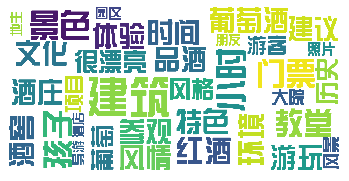

In [9]:
#创建词云
font = "C:\\Windows\\Fonts\\HGZY_CNKI.TTF"#词云的中文字体所在路径
wc = wordcloud.WordCloud(
    scale = 7,
    background_color="white", #背景颜色
    #max_words=200, #显示最大词数
    font_path=font,
    min_font_size=15,
    max_font_size=50, 
    width=400  #图幅宽度
    )
wc.generate(cloud_text)

plt.imshow(wc)
plt.axis("off")
plt.show()

# LDA主题分析

In [10]:
# 主题分析
text_dict = corpora.Dictionary(text_list) # 创建语料的词语词典，每个单独的词语都会被赋予一个索引
text_corpus = [text_dict.doc2bow(i) for i in text_list] #创建语料库
tfidf = models.TfidfModel(text_corpus)
corpus_tfidf = tfidf[text_corpus]

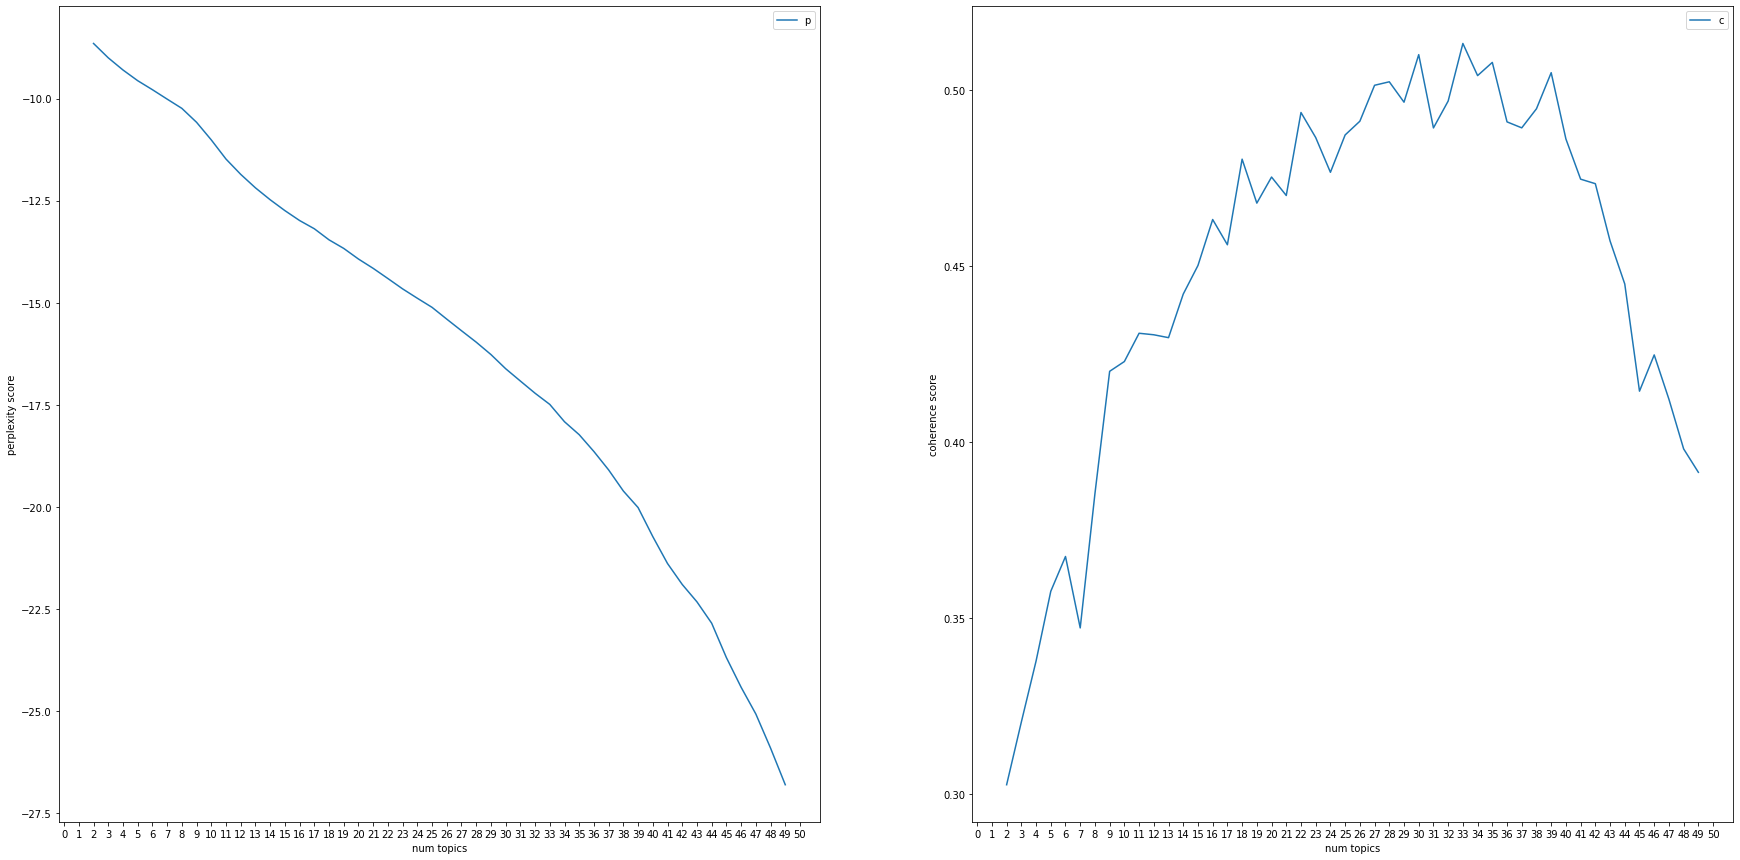

In [43]:
#模型评估：困惑度 &一致度
x_list = []
y_plist =[]
y_clist =[]
for i in range(2,50):
    text_lda = models.LdaModel(corpus_tfidf,num_topics = i,id2word =text_dict ) # LDA模型训练
    #困惑度
    perplexity = text_lda.log_perplexity(corpus_tfidf)  
    #一致度
    cv_tmp = models.CoherenceModel(model=text_lda,texts=text_list, dictionary=text_dict, coherence='c_v')
    x_list.append(i)
    y_plist.append(perplexity)
    y_clist.append(cv_tmp.get_coherence())
#困惑度绘图    
plt.figure(figsize=(30,15))    
plt.subplot(1,2,1)
plt.plot(x_list,y_plist)
plt.xticks(np.linspace(0, 50, 51))
plt.xlabel('num topics')
plt.ylabel('perplexity score')
plt.legend(('perplexity_values'), loc='best')
#一致度绘图
plt.subplot(1,2,2)
plt.plot(x_list,y_clist)
plt.xticks(np.linspace(0, 50, 51))
plt.xlabel('num topics')
plt.ylabel('coherence score')
plt.legend(('coherence_values'), loc='best')

plt.show()

In [13]:
#根据以上模型评估结果分析最优主题数目

In [11]:
#最优主题数目下的LDA主题模型
n = 5
lda = models.LdaModel(text_corpus,num_topics =n,id2word =text_dict ) # LDA模型训练  该最优主题数为32
for i in range(n):
    print('topic' + str(i))
    print(lda.print_topic(i)) # 输出每个主题

topic0
0.058*"环境" + 0.040*"游玩" + 0.032*"景色" + 0.025*"性价比" + 0.025*"小时" + 0.019*"面积" + 0.015*"设施" + 0.014*"体验" + 0.014*"场景" + 0.014*"酒庄"
topic1
0.034*"历史" + 0.028*"故事" + 0.028*"文化" + 0.027*"酒窖" + 0.027*"葡萄酒" + 0.025*"孩子" + 0.025*"导游" + 0.021*"时间" + 0.018*"体验" + 0.018*"院落"
topic2
0.033*"物件" + 0.025*"建筑" + 0.022*"人们" + 0.019*"宅院" + 0.019*"房子" + 0.018*"家人" + 0.011*"花园" + 0.011*"参观" + 0.010*"父母" + 0.010*"国家"
topic3
0.069*"老人" + 0.024*"孩子" + 0.022*"很漂亮" + 0.021*"红酒" + 0.020*"导游" + 0.018*"想象" + 0.017*"服务态度" + 0.017*"门票" + 0.017*"购票" + 0.014*"开花"
topic4
0.071*"地主" + 0.035*"历史" + 0.029*"建筑" + 0.024*"故宫" + 0.021*"民间" + 0.019*"文化" + 0.017*"特点" + 0.015*"小时" + 0.013*"景色" + 0.013*"规模"


In [12]:
#可视化模型，帮助理解主题
vis_data = pyLDAvis.gensim.prepare(lda, text_corpus,text_dict)
pyLDAvis.show(vis_data, open_browser=False)

D:\anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))



Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [01/Jul/2020 15:32:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Jul/2020 15:32:06] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [01/Jul/2020 15:32:06] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [01/Jul/2020 15:32:06] "GET /LDAvis.js HTTP/1.1" 200 -
127.0.0.1 - - [01/Jul/2020 15:32:06] code 404, message Not Found
127.0.0.1 - - [01/Jul/2020 15:32:06] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...


In [16]:
#得到每个文档（每评论文本）的主导主题
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [17]:
#文档中贡献百分比最高的主题
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=text_corpus, texts=data)# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']# Show
df_dominant_topic.head(10)
#df_dominant_topic['Dominant_Topic'].value_counts().plot(kind='bar')

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5635,"游玩, 历史, 小时, 建筑, 景色, 时期, 文化, 服务态度, 环境, 品酒",非常棒，如果去山西看大院或者民居，绝对不容错过，首先有规模，12万平方米，乔家一个院，常家两...
1,1,3.0,0.9177,"酒窖, 古树, 红酒, 葡萄酒, 建筑, 酒庄, 风景, 意义, 机会, 参观",晋中最好玩最值得一去的地方啦。交通便利，市内公车一小时直达。庄园很大很美丽，多部影视剧的取景...
2,2,2.0,0.9008,"地主, 故宫, 民间, 历史, 文化, 建筑, 小时, 地主家, 风情, 大院",乔家大院、王家大院、常家庄园相比，感觉常家庄园最好，王家大院次之，乔家大院相比之下根本不值一...
3,3,1.0,0.5566,"游玩, 历史, 小时, 建筑, 景色, 时期, 文化, 服务态度, 环境, 品酒",这个景点不适合冬天去游览的，我们2月初从太原站对面坐901到榆次老城再转12才到常家庄园的，...
4,4,0.0,0.5899,"环境, 规模, 宅院, 很漂亮, 景色, 气派, 整体, 家风, 古色古香, 花园",很不错，值得一去，儒家思想，比乔家大院有思想，后花园也不错，景色宜人，流连忘返啊，是许多电影...
5,5,3.0,0.7288,"酒窖, 古树, 红酒, 葡萄酒, 建筑, 酒庄, 风景, 意义, 机会, 参观",常家庄园中国儒商第一家，园林建筑于一体，真的是非常大气，晋商大院里面最喜欢的就是常家庄园，文...
6,6,3.0,0.8297,"酒窖, 古树, 红酒, 葡萄酒, 建筑, 酒庄, 风景, 意义, 机会, 参观",晋商创业精神值得学习，后花园杏园很大，儒商，值得一去。导游小姑娘讲解的也不错，门口常家家宴价...
7,7,2.0,0.6988,"地主, 故宫, 民间, 历史, 文化, 建筑, 小时, 地主家, 风情, 大院",常家庄园位于榆次，要是从太原出发的话，可以先坐公交车901路到达榆次老城终点站，3元，一个半...
8,8,2.0,0.9259,"地主, 故宫, 民间, 历史, 文化, 建筑, 小时, 地主家, 风情, 大院",正月十一去的，人少，很清静。细细的品味常家的家庭教育，体味晋商的深厚文化底蕴。建筑的砖雕、木...
9,9,0.0,0.8842,"环境, 规模, 宅院, 很漂亮, 景色, 气派, 整体, 家风, 古色古香, 花园",今天去的，感觉建筑大气磅礴，很壮观，值得大家去看一看，可想当时主人的财富！可以想而知当时的晋...


In [18]:
len(df_dominant_topic)

4081

# 通过可视化模型以及每个主题的主导文档手动合并几个主题，然后再进行下一步（情感分析）

In [34]:
df_dominant_topic['Topic'] = None
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([3])] = '特色产业'
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([2])] = '特色历史文化'
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([4,1])] = '游玩感受'
df_dominant_topic.Topic[df_dominant_topic.Dominant_Topic.isin([0])] = '特色环境风景'
df_dominant_topic.fillna('others',inplace = True)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCo

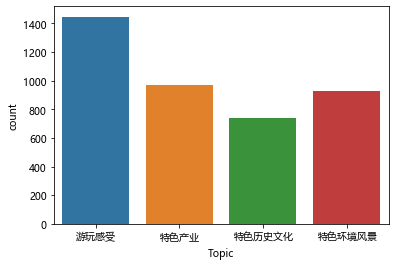

In [35]:
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
sns.countplot(df_dominant_topic['Topic'])

#  情感分析

In [36]:
Attitude = []    
for i, v in df_dominant_topic['Text'].iteritems():
    s = SnowNLP(v)
    Attitude.append(s.sentiments)
df_dominant_topic['Attitude'] = Attitude

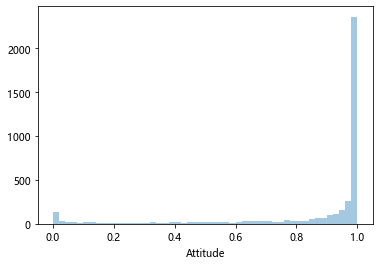

In [37]:
#所有主题的情感倾向分布情况
sns.distplot(df_dominant_topic['Attitude'],kde = False)

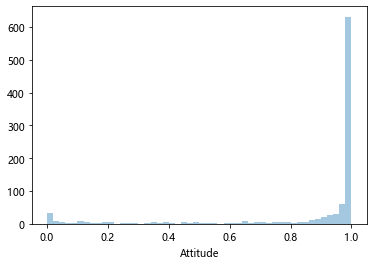

In [49]:
#某个主题的情感倾向分布情况-自然风景
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='特色产业']['Attitude'],kde = False)# 主题35的情感倾向

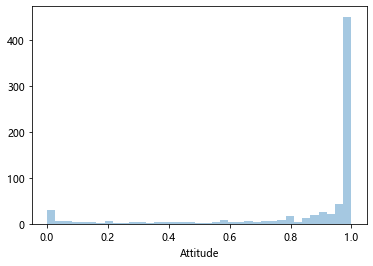

In [50]:
#某个主题的情感倾向分布情况-人文环境
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='特色历史文化']['Attitude'],kde = False)# 主题35的情感倾向

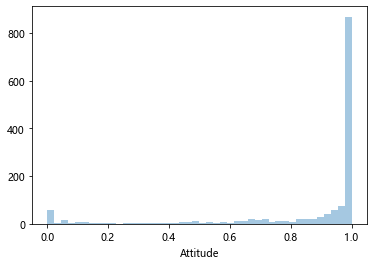

In [51]:
#某个主题的情感倾向分布情况-用户体验
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='游玩感受']['Attitude'],kde = False)# 主题35的情感倾向

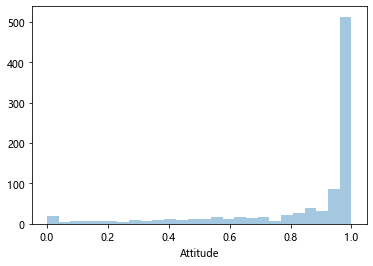

In [52]:
#某个主题的情感倾向分布情况-民俗文化
sns.distplot(df_dominant_topic[df_dominant_topic['Topic']=='特色环境风景']['Attitude'],kde = False)# 主题35的情感倾向

# 统计分析

In [42]:
df_gender_fans_sta = pd.merge(df,df_dominant_topic,left_on='text',right_on='Text',how='inner')[['gender','粉丝','text','Topic']]

In [43]:
df_gender_fans_sta.dropna(inplace = True)

In [44]:
df_gender_fans_sta.groupby(['Topic','gender']).count().T

Topic    游玩感受        特色产业      特色历史文化      特色环境风景     
gender female male female male female male female male
粉丝        855  755    550  520    409  404    472  538
text      855  755    550  520    409  404    472  538

In [45]:
index = df_gender_fans_sta['Topic'].value_counts(normalize = True, dropna = False).index
statistics = df_gender_fans_sta.groupby(['Topic','gender']).text.count().T.values.tolist()

female_count = df_gender_fans_sta[ df_gender_fans_sta['gender']=='female'].shape[0]   #男游客评论人数
male_count = df_gender_fans_sta[ df_gender_fans_sta['gender']=='male'].shape[0]       #女游客评论人数

a,b = [],[]
for i in range(len(statistics)):                                                      #标准化
    if i%2 ==0:
        a.append(statistics[i]/female_count)
    else:
        b.append(statistics[i]/male_count)
for i in range(len(a)):
    a[i],b[i] = a[i]/(a[i]+b[i]),b[i]/(a[i]+b[i])

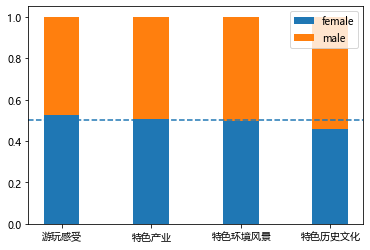

In [46]:
plt.bar(index, a, width=0.4, label='female')
plt.bar(index, b, width=0.4, bottom=a, label= 'male')
plt.axhline(y = 0.5,ls ='--')
plt.legend()
plt.show()

In [47]:
fans_sta = df_gender_fans_sta[df_gender_fans_sta['粉丝']>500].groupby('Topic').text.count()
fans_sta

Topic
游玩感受      66
特色产业      59
特色历史文化    35
特色环境风景    24
Name: text, dtype: int64

<BarContainer object of 4 artists>

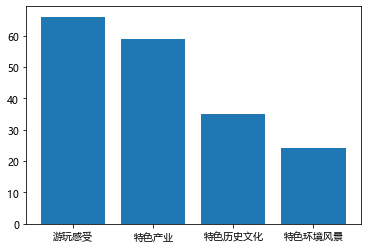

In [48]:
plt.bar(fans_sta.index,fans_sta.tolist())

In [16]:
s = SnowNLP("我的心情很糟糕啊，不建议去")
s.sentiments

0.19188686736463656

In [44]:
#找到给定主题最有贡献的文档，并通过阅读该文档来推断该主题
#sent_topics_sorteddf_mallet = pd.DataFrame()

#sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

#for i, grp in sent_topics_outdf_grpd:
#    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],  axis=0)# Reset Index
#sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)# Format
#sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]# Show
#sent_topics_sorteddf_mallet

In [45]:
#主题的数量和分布
#topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()# Percentage of Documents for Each Topic
#topic_contribution = round(topic_counts/topic_counts.sum(), 4)# Topic Number and Keywords
#topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]# Concatenate Column wise
#df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)# Change Column names
#df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']# Show
#df_dominant_topics